In [4]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from models import Cnn, FCNN

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), '..')))
from etl_data_preparing import DataPrepareETL

In [2]:
model = FCNN()

In [3]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

In [4]:
train_loader, (X_valid, y_valid), (X_test, y_test) = DataPrepareETL(
    data="../preprocessing/data/BTCUSDT.csv",
    scaler="./static/BTCUSDT_MinMaxScaler.pkl"
).prepare_for_train(valid_size=.10, test_size=.10)

In [ ]:
static_dir = "static/"
best_model_filename = os.path.join(static_dir, "best_CNN.pkl")
train(epochs=1, best_model_filename=best_model_filename, test_count=1000)

In [ ]:
n_components=32
n_clusters = 5

pca = PCA(n_components=32)
kmeans = KMeans(n_clusters=n_clusters)


for X_batch, y_batch in train_loader:
    with torch.no_grad():
        features = model.cnn(X_batch)
    features = torch.nn.Flatten()(features)
    features_pca = pca.fit_transform(features.cpu().numpy())
    clusters = kmeans.fit_predict(features_pca)

# Utils

In [6]:
def mae(x, y):
    with torch.no_grad():
        out = model(x)
        errors = abs(out - y)
    return errors

def train_one_epoch():
    train_losses = list()
    val_losses = list()
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.zero_grad()
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        loss.backward()
        optimizer.step()

        if (i+1) % 25 == 0:
            train_losses.append(loss.item())
            with torch.no_grad():
                val_out = model(X_valid)
                val_loss = loss_function(val_out, y_valid)
            val_losses.append(val_loss.item())

        if (i+1) % 100 == 0:
            print(f"Train Itteration: {i+1}, Train Loss: {loss.item()}, Valid Loss: {val_loss.item()}")

    return train_losses, val_losses


def train(epochs: int, best_model_filename: str, test_count: int = 1000):
    best_error = np.inf
    train_losses = list()
    val_losses = list()
    for epoch in range(epochs):
        tl, vl = train_one_epoch()
        train_losses.extend(tl)
        val_losses.extend(vl)
        epoch_errors = list()
        for i in range(0, test_count, 100):
            epoch_errors.append(mae(X_valid[i:i+100], y_valid[i:i+100]))
        epoch_errors = torch.cat(epoch_errors)
        if epoch_errors.mean().item() < best_error:
            torch.save(model, best_model_filename)
            best_error = epoch_errors.mean().item()
        print("Epoch:", epoch+1, "MAE:", epoch_errors.mean().item(), "STD:", epoch_errors.std().item())
    return train_losses, val_losses


In [3]:
history = json.load(open("./static/cnn train history.json"))
history

{'train': [0.02484680712223053,
  0.0014691577525809407,
  0.0004100120859220624,
  4.491915387916379e-05,
  6.722153921145946e-05,
  4.757156420964748e-05,
  2.0151190256001428e-05,
  1.9813211110886186e-05,
  0.00013113800378050655,
  3.0544943001586944e-05,
  0.00020036316709592938,
  0.0009574078721925616,
  9.25386484595947e-05,
  2.7874128136318177e-05,
  2.9154767617001198e-05,
  2.1388412278611213e-05,
  4.1251903894590214e-05,
  1.0162377293454483e-05,
  0.00011786803952418268,
  0.00018215569434687495,
  0.0002264156937599182,
  0.00034345267340540886,
  0.000377585762180388,
  0.00010941953951260075,
  0.00010257065878249705,
  3.2788033422548324e-05,
  1.5278206774382852e-05,
  6.303890404524282e-05,
  3.837573603959754e-05,
  1.1361621545802336e-05,
  0.0036722570657730103,
  0.0001613205240573734,
  1.8496379198040813e-05,
  2.3720600438537076e-05,
  2.2238495148485526e-05,
  1.0880934496526606e-05,
  1.393617731082486e-05,
  1.3467768440023065e-05,
  8.86645502760075e-05

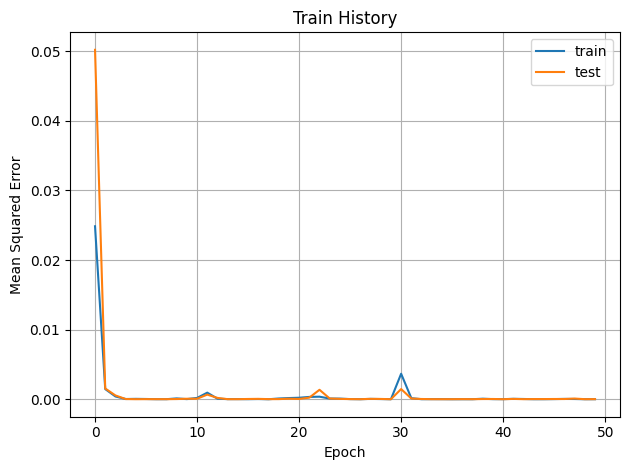

In [12]:
plt.plot(history["train"][:50], label="train")
plt.plot(history["valid"][:50], label="test")
plt.legend()
plt.title("Train History")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.tight_layout()
plt.savefig("./static/train history 50 epochs")